# Tools - Edge Seal Oxygen Ingress Calculator tool

### Calculation of oxygen ingress profile through an edge seal and into the encapsulant.

**Requirements:**
- Local weather data file or site longitude and latittude.
- Properties and dimensions of the edge seal.

**Objectives:**
1. Import weather data.
2. Set up the calculations.
3. Calculate oxygen ingress into an edge seal.
3. Incorporate an oxygen consumption model.
4. Plot the data.

**Background:**

This performs a 1-D finite difference model for oxygen ingress through an edge seal and into an encapsulant. This is effectively an infinitely long module with a prescribed width.The output is then displayed graphically.

In [1]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
# !pip install pvdeg==0.4.2

In [2]:
import os
import pvdeg
import pandas as pd
from pvdeg import DATA_DIR
import matplotlib.pyplot as plt
import numpy as np
import json

In [3]:
# This information helps with debugging and getting support :)
import sys, platform
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("pvdeg version ", pvdeg.__version__)

Working on a  Windows 11
Python version  3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)]
Pandas version  2.2.3
pvdeg version  0.5.1.dev623+g51cc68b8e.d20250905


## 1. Import Weather Data

The function has these minimum requirements when using a weather data file:
- Weather data containing (at least) DNI, DHI, GHI, Temperature, RH, and Wind-Speed data at module level.
- Site meta-data containing (at least) latitude, longitude, and time zone

Alternatively one may can get meterological data from the NSRDB or PVGIS with just the longitude and latitude. This function for the NSRDB (via NSRDB 'PSM3') works primarily for most of North America and South America. PVGIS works for most of the rest of the world (via SARAH 'PVGIS'). See the tutorial "Weather Database Access.ipynb" tutorial on PVdeg or Jensen et al. https://doi.org/10.1016/j.solener.2023.112092 for satellite coverage information.

In [4]:
# Get data from a supplied data file (Do not use the next box of code if using your own file)
weather_file = os.path.join(DATA_DIR, "psm3_demo.csv")
weather_df, meta = pvdeg.weather.read(weather_file, "psm")
print(sorted(meta.keys()))

['City', 'Clearsky DHI Units', 'Clearsky DNI Units', 'Clearsky GHI Units', 'Cloud Type -15', 'Cloud Type 0', 'Cloud Type 1', 'Cloud Type 10', 'Cloud Type 11', 'Cloud Type 12', 'Cloud Type 2', 'Cloud Type 3', 'Cloud Type 4', 'Cloud Type 5', 'Cloud Type 6', 'Cloud Type 7', 'Cloud Type 8', 'Cloud Type 9', 'Country', 'DHI Units', 'DNI Units', 'Dew Point Units', 'Fill Flag 0', 'Fill Flag 1', 'Fill Flag 2', 'Fill Flag 3', 'Fill Flag 4', 'Fill Flag 5', 'GHI Units', 'Location ID', 'Precipitable Water Units', 'Pressure Units', 'Relative Humidity Units', 'Solar Zenith Angle Units', 'Source', 'State', 'Surface Albedo Units', 'Temperature Units', 'Version', 'Wind Direction Units', 'Wind Speed Units', 'altitude', 'latitude', 'longitude', 'tz']


In [5]:
# This routine will get a meteorological dataset from anywhere in the world where it is available
# weather_id = (24.7136, 46.6753) #Riyadh, Saudi Arabia
# weather_id = (35.6754, 139.65) #Tokyo, Japan
# weather_id = (-43.52646, 172.62165) #Christchurch, New Zealand
# weather_id = (64.84031, -147.73836) #Fairbanks, Alaska
# weather_id = (65.14037, -21.91633) #Reykjavik, Iceland
weather_id = (33.4152, -111.8315)  # Mesa, Arizona
weather_df, meta = pvdeg.weather.get_anywhere(id=weather_id, database="PVGIS")
print(meta)

{'latitude': 33.4152, 'longitude': -111.8315, 'irradiance_time_offset': 0.0, 'altitude': 381.0, 'wind_height': 10, 'Source': 'PVGIS'}


In [6]:
# This computes a module temperature. Here the default is an open rack system, but other options include:
#       'open_rack_glass_glass',
#       'close_mount_glass_glass',
#       'insulated_back_glass_polymer'

temperature = pvdeg.temperature.temperature(
    weather_df=weather_df,
    meta=meta,
    cell_or_mod="module",
    temp_model="sapm",
    conf="open_rack_glass_polymer",
)

temperature = pd.DataFrame(temperature, columns=["module_temperature"])
temperature["time"] = list(range(8760))

The array surface_tilt angle was not provided, therefore the latitude of  33.4 was used.
The array azimuth was not provided, therefore an azimuth of  180.0 was used.


## 2. Set up the Calculations

There is a library of some materials and the relevant oxygen ingress parameters that can be used.

In [7]:
es = "OX005"  # This is the number for the edge seal in the json file
enc = "OX003"  # This is the number for the encapsulant in the json file
esw = 1.5  # This is the edge seal width in [cm]
encw = 10  # This is the encapsulant width in [cm]
sn = 20  # This is the number of edge seal nodes to use
en = 50  # This is the number of encapsulant nodes to use
pressure = 0.2109 * (1 - 0.0065 * meta.get("altitude") / 288.15) ** 5.25588
print(pvdeg.utilities.read_material(pvdeg_file="O2permeation",key="OX003"))
print(pvdeg.utilities.read_material(pvdeg_file="H2Opermeation", key="W003"))

{'name': 'EVA', 'alias': 'EVA-1', 'contributor': 'Michael Kempe', 'source': 'unpublished measurements', 'Fickian': True, 'Ead': {'name': 'Diffusivity Activation Energy', 'units': 'kJ/mol', 'value': 29.43112031}, 'Do': {'name': 'Diffusivity Prefactor', 'units': 'cm²/s', 'value': 0.129061678}, 'Eas': {'name': 'Solubility Activation Energy', 'units': 'kJ/mol', 'value': 16.6314948252219}, 'So': {'name': 'Solubility Prefactor', 'units': 'g/cm³/atm', 'value': 0.136034525059804}, 'Eap': {'name': 'Permeability Activation Energy', 'units': 'kJ/mol', 'value': 49.1083457348515}, 'Po': {'name': 'Permeability Prefactor', 'units': 'g·mm/m²/day/atm', 'value': 528718258.338532}}
{'name': 'Coveme', 'alias': 'Stabilized PET', 'contributor': 'Michael Kempe', 'source': 'unpublished measurements', 'Fickian': True, 'Ead': {'name': 'Diffusivity Activation Energy', 'units': 'kJ/mol', 'value': 47.5191721120378}, 'Do': {'name': 'Diffusivity Prefactor', 'units': 'cm²/s', 'value': 1.31884541208636}, 'Eas': {'name

## 3. Run the Calculations

This runs the calculations for diffusion using a simple 1-D finite difference calculation. The first set of calculations is just for diffusion, then the next two (when written) will include some consumption of oxygen. In typical PV applications, it is common for oxygen ingress distance to be limited by its consumption rate in the encapsulant.

In [8]:
oxygen_profile = pvdeg.diffusion.esdiffusion(
    temperature=temperature,
    edge_seal=es,
    encapsulant=enc,
    edge_seal_width=esw,
    encapsulant_width=encw,
    seal_nodes=sn,
    encapsulant_nodes=en,
    press=pressure,
    repeat=2,
)

Oxygen ingress parameters loaded for the edge seal.
Oxygen ingress parameters loaded for the encapsulant.
The edge seal is Helioseal_101_dry .
The encapsulant is EVA .


In [9]:
# This sets up an a variable with the output folder information.
output_folder = os.path.join(
    os.path.dirname(os.path.dirname(os.getcwd())), "TEMP", "results"
)
try:
    os.makedirs(output_folder)
    print(f"Created directory: {output_folder}")
except OSError as error:
    print(error)

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\rdaxini\\Documents\\GitHub\\PVDegradationTools_NREL\\TEMP\\results'


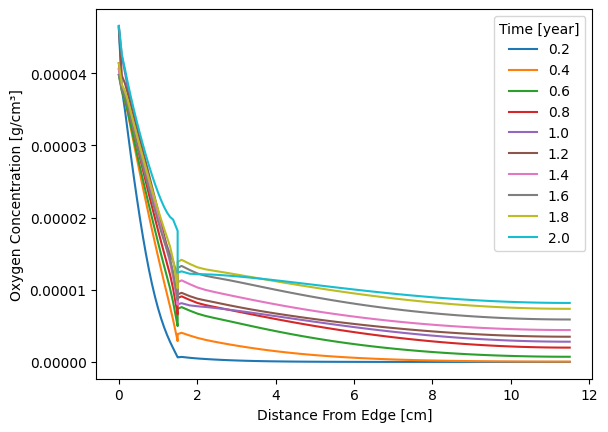

In [10]:
n_lines = 10
times = oxygen_profile.index.tolist()
for index in range(n_lines):
    plt.plot(
        oxygen_profile.iloc[
            int(np.trunc((index + 1) * (len(oxygen_profile) - 1) / n_lines))
        ],
        label=np.round(
            times[int(np.trunc((index + 1) * ((len(oxygen_profile) - 1) / n_lines)))]
            / 365.25
            / 24,
            2,
        ),
    )
plt.legend(title="Time [year]")
plt.ylabel("Oxygen Concentration [g/cm³]")
plt.xlabel("Distance From Edge [cm]")
plt.ticklabel_format(axis="y", style="plain")

plt.savefig(
    os.path.join(output_folder, "Edge_Seal_O2_ingress.png"), bbox_inches="tight"
)  # Creates an image file of the standoff plot
plt.show()

## 5. Save data outputs.

This cell contains a number of pre-scripted commands for exporting and saving data. The code to save plots is located after the plot creation. First check that the output folder exists.

In [11]:
fpath = os.path.join(DATA_DIR, "O2permeation.json")
with open(fpath) as f:
    data = json.load(f)
f.close()

material_list = ""
for key in data:
    if "name" in data[key].keys():
        material_list = material_list + key + "=" + data[key]["name"] + "\n"
material_list = material_list[0 : len(material_list) - 1]
print(material_list)

OX001=Tedlar
OX002=ST504
OX003=EVA
OX004=AAA polyamide backsheet
OX005=Helioseal_101_dry
OX006=Helioseal_101_wet
OX007=LPO3_dry
OX008=LPO3_wet
OX009=Nagase_dry
OX010=Nagase_wet
OX011=Oppanol_B_200
OX012=EVA
OX013=polyolefin elastomer (POE)


In [12]:
print("Your results will be stored in %s" % output_folder)
print("The folder must already exist or the file will not be created")

# Writes the meterological data to an *.csv file.
pvdeg.weather.write(
    data_df=weather_df,
    metadata=meta,
    savefile=os.path.join(output_folder, "WeatherFile.csv"),
)

# Writes a file with the edge seal oxygen profile calculations.
pd.DataFrame(oxygen_profile).to_csv(
    os.path.join(output_folder, "ES_Oxygen_profile.csv")
)

# Writes a file with temperature data used in the model calculations.
pd.DataFrame(temperature).to_csv(
    os.path.join(output_folder, "ES_Temperature_profile.csv")
)

Your results will be stored in C:\Users\rdaxini\Documents\GitHub\PVDegradationTools_NREL\TEMP\results
The folder must already exist or the file will not be created
